# T022 - Ligand-based screening: Neural networks

Developed in the CADD seminar 2020, Volkamer Lab, Charité/FU Berlin 

Authors : 
- Sakshi Misra, [Volkamer lab](https://volkamerlab.org), Charité
- Talia B. Kimber, [Volkamer lab](https://volkamerlab.org), Charité
- Prof. Dr. Andrea Volkamer, [Volkamer lab](https://volkamerlab.org), Charité

## Aim of this talktorial

In this talktorial, we will get familiar with the mechanism of the artificial neural network. Furthermore, we will learn how to build a simple two layer neural network model and use it to predict the PIC50 values of unknown compounds against our target of interest (EGFR).

### Contents in *Theory*

- Basic Background
   - Molecular fingerprints
   - IC50
   - EGFR
- What is a neural network? 
   - Basic structure
   - Main algorithms 
   - Activation function
      - Types of activation function

### Contents in *Practical*

- Load molecules and visualize the dataframe
- Data Preparation : Molecule encoding
- Neural network


### References

-
-
-



## Theory

### Basic Background

#### Molecular fingerprints

Molecular fingerprints represent the chemical structures in bit strings form as each position mean the presence (1) or absence (0) of chemical features as defined in the design of the fingerprint.one of common fingerprint is molecular ACCess System (MACCS) fingerprints (MACCS Keys) which are 166 bits structural key descriptors in which each bit is associated with a SMARTS pattern  which is the same as smiles with some extensions and flexibility [SMARTS :A Language for Describing Molecular Patterns](https://www.daylight.com/dayhtml/doc/theory/theory.smarts.html)
[RDKit documentation: MACCS keys](http://rdkit.org/docs/source/rdkit.Chem.MACCSkeys.html)

#### Compound activity measures (IC50)

IC50 is half maximal concentration of inhibitory drug to inhibit the activity of specific enzyme and in our case the Epidermal growth factor receptor as its Inhibition helps in slow down or stop cancer cell growth. Using **pIC50** (the negative log of the IC50 value) because it is easy for interpretation than IC50 and common for potency of compounds 

#### EGFR

Epidermal growth factor receptor (EGFR) is a transmembrane protein activated by binding of its specific ligands and it included in the cell growth process. It is also be found at high levels on some types of cancer cells, which causes these cells to grow and divide quickly so one of the approaches in treatment the cancer is inhibiting EGFR receptor. To determine the efficacy of drugs that can inhibit EGFR we measure IC50 (PIC50) to the drug and in this project, we will build model to predict the PIC50 of drugs from its smiles and fingerprint.

### What is a neural network?

Neural networks are connection of neurons that mimic the brain neurons and each connection can transfer information from one neuron to another like Synapse in natural neural cells.



#### Basic structure

Neural network consist of three main layers:
1. Input layers which are equal to the number of features of input data 
2. Hidden layers in the middle between the input and output layers 
3. Output layer are the observations of input data.


The connection between each layer depend mainly on the output of previous connecting neurons from the previous layer, weights of connecting edges between neurons and the activation function in neuron itself, which all give a new output to the forward neurons in next layer. 

#### Main algorithms 

The main algorithms for neural network: forward, back propagation, optimization function (gradient descent).
1. **Forward propagation**: It takes all first assumption of weights that affect on node with the output values of nodes from previous layer then add them to be as input to the node and with the activation function of this node , it gives output which can be used with the weights of the next edges as input to the forward nodes in next layer.

2. **Back propagation**: It starts from the last layer (output layer) and go backward until input layer. at the output layer , nodes have values from forward propagation but these values are different from the actual values that are given to model so with specific loss function for example mean squared error **as in this project** calculate the loss function between the actual and predicted values in nodes in output layer . After that according to the value of loss function  back propagation try to change the weights of edges to reach optimum solution and this occur by optimization function.

3. **Gradient descent (optimization function)**: It tries to guide the algorithm how can reduce the loss function to reach the global solution by changing the values of weights in backward process from the weights of hidden layer to weights of input layer then repeat the forward propagation again and so on until convergence  the global solution and lowest value loss cost. there are more than type of optimization function but we use here 'ADAM' as it Computationally efficient and Little memory requirements. we can also say briefly that the mathematical overview  of gradient descent depend mainly on: 
  * At lowest point (lowest cost function ) of curve , the differential equation of function at this point = zero
  * chain rule to get the partial differential equation ( relation between each weight and the final loss function)


**Types of loss function**:
1. mean squared error : used mainly in regression problem as in this project 
2. cross entropy: used in case of classification 

#### Activation function


##### Types of activation function

1. Linear function used in case of regression mainly in the output layer as in this project.
2. Non linear functions such as 
   * logistic (Sigmoid) function which gives output values between 0 and 1 so it is good mainly in prediction of probability. 
   * Softmax function is more generalized logistic regression function and used in multiple classification.
   * Rectified Linear Unit (ReLU) which is most common and gives range from 0 and positive Infinity so negative input to 
     (RelU) function turns directly to zero and this causes a decreasing in the performance of the model to fit or train from        the data and this problem called **Dying ReLU**.
   * Leaky ReLU activation function that can solve this problem of dying ReLU as it can be used with negative inputs.
   

## Practical

In [1]:
from pathlib import Path
from warnings import filterwarnings
import time

import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import MACCSkeys, Draw
from sklearn.model_selection import KFold, train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

# Neural network specific libraries
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
%matplotlib inline
from pathlib import Path

# Silence some expected warnings
filterwarnings("ignore")

### Load molecules and visualize the dataframe

Let's start by loading our data which is the subset of ChEMBL dataset and visulaize the dataframe, the importannt columns in the dataframe are:

- CHEMBL-ID
- SMILES string of the corresponding compound
- Measured affinity: pIC50

In [2]:
# Set path to this notebook
HERE = Path(_dh[-1])
DATA = HERE / "data"

df = pd.read_csv(DATA/'CHEMBL25_activities_EGFR.csv',
                 lineterminator='\n', index_col=0) # NBVAL_CHECK_OUTPUT

In [3]:
# Check the dimension and missing value of the data 
print("Shape of dataframe : ", df.shape) 
df.info()

# Look at head
df.head() # NBVAL_CHECK_OUTPUT

Shape of dataframe :  (3906, 5)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3906 entries, 1777 to 2783
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   chembl_id         3906 non-null   object 
 1   IC50              3906 non-null   float64
 2   units             3906 non-null   object 
 3   canonical_smiles  3906 non-null   object 
            3906 non-null   float64
dtypes: float64(2), object(3)
memory usage: 183.1+ KB


,chembl_id,IC50,units,canonical_smiles,pIC50\r
1777,CHEMBL207869,77.0,nM,Clc1c(OCc2cc(F)ccc2)ccc(Nc2c(C#Cc3ncccn3)cncn2)c1,7.113509
5785,CHEMBL3940060,330.0,nM,ClCC(=O)OCCN1C(=O)Oc2c1cc1c(Nc3cc(Cl)c(F)cc3)n...,6.481486
6373,CHEMBL3678951,1.0,nM,FC(F)(F)c1cc(Nc2n(C(C)C)c3nc(Nc4ccc(N5CC[NH+](...,9.000000
2442,CHEMBL504034,40.0,nM,Clc1c(OCc2cc(F)ccc2)ccc(Nc2ncnc3c2sc(C#C[C@H]2...,7.397940
1084,CHEMBL158797,43000.0,nM,S(Sc1n(C)c2c(c1C(=O)NCC(O)CO)cccc2)c1n(C)c2c(c...,4.366531


In [4]:
# Keep only the columns we want
chembl_df = df[["chembl_id", "canonical_smiles", "pIC50\r"]]
chembl_df.head()
# NBVAL_CHECK_OUTPUT

,chembl_id,canonical_smiles,pIC50\r
1777,CHEMBL207869,Clc1c(OCc2cc(F)ccc2)ccc(Nc2c(C#Cc3ncccn3)cncn2)c1,7.113509
5785,CHEMBL3940060,ClCC(=O)OCCN1C(=O)Oc2c1cc1c(Nc3cc(Cl)c(F)cc3)n...,6.481486
6373,CHEMBL3678951,FC(F)(F)c1cc(Nc2n(C(C)C)c3nc(Nc4ccc(N5CC[NH+](...,9.000000
2442,CHEMBL504034,Clc1c(OCc2cc(F)ccc2)ccc(Nc2ncnc3c2sc(C#C[C@H]2...,7.397940
1084,CHEMBL158797,S(Sc1n(C)c2c(c1C(=O)NCC(O)CO)cccc2)c1n(C)c2c(c...,4.366531


### Data Preparation

#### Molecule encoding
Now we use already defined function `smiles_to_fp` from Talktorial **T007** to generate fingerprints from SMILES. 

It will generate fingerprints of the molecules TODO

In [5]:
def smiles_to_fp(smiles, method="maccs", n_bits=2048):
    """
    Encode a molecule from a SMILES string into a fingerprint.

    Parameters
    ----------
    smiles : str
        The SMILES string defining the molecule.

    method : str
        The type of fingerprint to use. Default is MACCS keys.

    n_bits : int
        The length of the fingerprint.

    Returns
    -------
    array
        The fingerprint array.

    """

    # convert smiles to RDKit mol object
    mol = Chem.MolFromSmiles(smiles)

    if method == "maccs":
        return np.array(MACCSkeys.GenMACCSKeys(mol))
    if method == "morgan2":
        return np.array(GetMorganFingerprintAsBitVect(mol, 2, nBits=n_bits))
    if method == "morgan3":
        return np.array(GetMorganFingerprintAsBitVect(mol, 3, nBits=n_bits))
    else:
        # NBVAL_CHECK_OUTPUT
        print(f"Warning: Wrong method specified: {method}. Default will be used instead.")
        return np.array(MACCSkeys.GenMACCSKeys(mol))

In [6]:
# convert all SMILES strings to MACC fingerprints
fingerprints_df = pd.DataFrame([smiles_to_fp(smile) for smile in chembl_df['canonical_smiles']])
fingerprints_df.shape

(3906, 167)

In [7]:
fingerprints_df.head(3)

,0,1,2,3,4,5,6,7,8,9,...,157,158,159,160,161,162,163,164,165,166
0,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,1,1,1,1,1,0
1,0,0,0,0,0,0,0,0,0,0,...,1,1,1,0,1,1,1,1,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,1,1,1,0,1,0


Now we have fingerprints of the molecules which are the features for training the neural network model, we can add labels which is the PIC50 value TODO

In [8]:
# add pic50 column
complete_df = fingerprints_df.join(chembl_df['pIC50\r'])
complete_df.head(2)

,0,1,2,3,4,5,6,7,8,9,...,158,159,160,161,162,163,164,165,166,pIC50\r
0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,1,1,1,1,1,0,NaN
1,0,0,0,0,0,0,0,0,0,0,...,1,1,0,1,1,1,1,1,0,6.769551


In [9]:
chembl_df

,chembl_id,canonical_smiles,pIC50\r
1777,CHEMBL207869,Clc1c(OCc2cc(F)ccc2)ccc(Nc2c(C#Cc3ncccn3)cncn2)c1,7.113509
5785,CHEMBL3940060,ClCC(=O)OCCN1C(=O)Oc2c1cc1c(Nc3cc(Cl)c(F)cc3)n...,6.481486
6373,CHEMBL3678951,FC(F)(F)c1cc(Nc2n(C(C)C)c3nc(Nc4ccc(N5CC[NH+](...,9.000000
2442,CHEMBL504034,Clc1c(OCc2cc(F)ccc2)ccc(Nc2ncnc3c2sc(C#C[C@H]2...,7.397940
1084,CHEMBL158797,S(Sc1n(C)c2c(c1C(=O)NCC(O)CO)cccc2)c1n(C)c2c(c...,4.366531
...,...,...,...
1560,CHEMBL309937,N(c1ncnc2[nH]c(C)c(C)c12)c1ccc(CC)cc1,4.110698
3780,CHEMBL1829271,Brc1cc(CC(=O)NS(=O)(=O)c2ccccc2)ccc1,4.607655
6207,CHEMBL3671533,Brc1cc(F)c(Nc2ncnc3c2cc(NC(=O)C=C)c(OCCNC(=O)C...,8.045757
3011,CHEMBL589826,Clc1c(F)ccc(Nc2ncnc3c2cc(OCCCCC=C)c(OC)c3)c1,7.486783


In [10]:
#complete_df['PIC50'] = chembl_df['pIC50\r'].copy()

In [11]:
# separate the inputs keys fp and the output pic50
X = complete_df.iloc[:, complete_df.columns != 'pIC50\r']
y = complete_df.iloc[:, -1]

In [12]:
X

,0,1,2,3,4,5,6,7,8,9,...,157,158,159,160,161,162,163,164,165,166
0,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,1,1,1,1,1,0
1,0,0,0,0,0,0,0,0,0,0,...,1,1,1,0,1,1,1,1,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,1,1,1,0,1,0
3,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0
4,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3901,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,1,1,1,0,1,0
3902,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,1,1,1,1,1,0
3903,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0
3904,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0


In [13]:
# Split the data into training and testing 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

In [14]:
print(X_train.shape, X_test.shape)

(2734, 167) (1172, 167)


### Neural network model

This overview figure for the model


In [15]:
# create own function

"""class Layer_Dense:
    def __init__(self, n_inputs, n_neurons):
        self.weights = 0.10 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros(1, n_neurons)
    def forward(self, inputs):
        self.output = np.dot(inputs, self.weights) + self.biases


class Activation_ReLU:
    def forward(self, inputs):
        self.output = np.maximum(0, inputs)


        
layer1 = Layer_Dense(167,50)
layer2 = Layer_Dense(50, 1)


activation1 = Activation_ReLU()
activation2 = Activation_ReLU()

layer1.forward(X)
layer1.forward(layer1.output)

activation1.foward(layer1.output)
activation2.foward(layer2.output)
print(activation2.output)

"""

'class Layer_Dense:\n    def __init__(self, n_inputs, n_neurons):\n        self.weights = 0.10 * np.random.randn(n_inputs, n_neurons)\n        self.biases = np.zeros(1, n_neurons)\n    def forward(self, inputs):\n        self.output = np.dot(inputs, self.weights) + self.biases\n\n\nclass Activation_ReLU:\n    def forward(self, inputs):\n        self.output = np.maximum(0, inputs)\n\n\n        \nlayer1 = Layer_Dense(167,50)\nlayer2 = Layer_Dense(50, 1)\n\n\nactivation1 = Activation_ReLU()\nactivation2 = Activation_ReLU()\n\nlayer1.forward(X)\nlayer1.forward(layer1.output)\n\nactivation1.foward(layer1.output)\nactivation2.foward(layer2.output)\nprint(activation2.output)\n\n'

In [16]:
def NN_model(hidden1, hidden2):
    """
    creating neural network from two hidden layer
    using relu as activation function in two hidden layer
    and linear in the output layer

    parameters
    ----------
    hidden1 : Int
              number of neuons in first hidden layer

    hidden2: Int
             number of neuons in second hidden layer
    Returns
    --------
    model fully connected neural network model with two hidden layer
    """

    model = Sequential()
    # first hidden layer
    model.add(Dense(hidden1, activation='relu', name="layer1"))
    # dropout prevent overfitting
    Dropout(.5)
    # second headden layer
    model.add(Dense(hidden2, activation='relu', name="layer2"))
    Dropout(.5)
    # output layer
    model.add(Dense(1, activation='linear', name="layer3"))

    # compile model

    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse', 'mae'])
    return model

### Choose the most appropriate batch sizes 

NameError: name 'static_train_x' is not defined

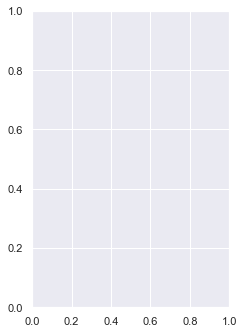

In [17]:
# trying different batch sizes

batch_sizes = [32, 64, 128, 256, 512]
# size of figure
fig = plt.figure(figsize=(12, 12))
sns.set(color_codes=True)
for i in range(1, 6):

    fig.add_subplot(2, 3, i)
    # creat new model
    model = NN_model(64, 32)
    history = model.fit(static_train_x, static_train_y, batch_size=batch_sizes[i-1],
                        validation_data=(static_test_x, static_test_y),
                        verbose=0, epochs=100)

    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='validation')
    plt.legend(['train', 'test'], loc='upper right')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.title('model loss in batch size = '+str(batch_sizes[i-1]))
plt.show()

### 5-fold cross-validation

In [ ]:
# take the values of both keys and pic50 to can be divided
x = keys.values
y = pic50.values

kf = KFold(5, shuffle=True, random_state=42)  # split the data to 5 fold

MSE = []  # empty list to add mean square error to all 5 folds

for j, (train, test) in enumerate(kf.split(keys)):

    print(f"Fold #{j+1}")

    x_train = x[train]  # macc_keys for training
    y_train = y[train]  # pic50 for training
    x_test = x[test]    # macc_keys for testing
    y_test = y[test]    # pic50 for tsting

    model = NN_model(64, 32)

    model.fit(x_train, y_train, batch_size=512, verbose=0, epochs=100)

    pred = model.predict(x_test)

    score = metrics.mean_squared_error(pred, y_test)

    print(f"MSE score for fold{j+1}: {score}")

    MSE.append(score)

# MSE for all 5 fold
print('=================================================')
print(f'all MSE for 5 CV:{MSE}')

std_all_MSE = np.std(MSE)
mean_all_MSE = np.mean(MSE)

print("================================================")

print(f"mean:{mean_all_MSE}")
print(f"standard deviation:{std_all_MSE}")

### Training new model on all data set 

In [ ]:
# creat new model

model = NN_model(64, 32)

# save the model
filepath = "weights_CV.best.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1,
                             save_best_only=True, mode='min')
callbacks_list = [checkpoint]
model.fit(keys, pic50, epochs=100, batch_size=512,
          callbacks=callbacks_list, verbose=0)

score = model.evaluate(keys, pic50)
print(f'score:{score}')

# predict all data
pred = model.predict(keys)

# ploting to distribution of training data around the model
sns.set(color_codes=True)
ax = sns.regplot(x=pic50, y=pred)
ax.set_title('Regression of prdicted keys with the model and original pic50 ')

### Loading and testing the model on EGFR_test_set.csv

In [ ]:
path_test_file = (r'https://raw.githubusercontent.com/volkamerlab/CADDSeminar_2020'
                  '/master/data/EGFR_test_set.csv?token=APMI3MRHVK3KQAH5VGVFET27AQRXI')

In [ ]:
test_df = pd.read_csv(path_test_file)

In [ ]:
test_df.head()

In [ ]:
smil_test = test_df['canonical_smiles']

In [ ]:
# convert all smiles in test file to maacc keys
maccs_test_df = pd.DataFrame([smil_to_maccfp(smile) for smile in smil_test])
maccs_test_df.head(3)

### Prediction  of pic50 of smiles in New file

In [ ]:
# load the model and predict the new smiles in test file
model = load_model("production_model.hdf5")
predicted_pic50 = model.predict(maccs_test_df)

In [ ]:
# adding the predicted pic50 to their smiles in df
predicted_pic50 = pd.DataFrame(predicted_pic50, columns=['T04_predictions'])
predicted_pic50_df = test_df.join(predicted_pic50)

predicted_pic50_df.head(3)

In [ ]:
# Histogram to the distribution of the predected pic50 in test file
plt.figure(figsize=(12, 12))
sns.set(color_codes=True)

plt.subplot(221)
plt.hist(predicted_pic50_df["T04_predictions"],
         facecolor='b', histtype='barstacked', range=(1, 10))
plt.xlabel('pic50')
plt.ylabel('count')
plt.title('range of predicted pic50')

plt.subplot(222)
plt.hist(maccs__fp_df_pic50["pIC50"], facecolor='g', range=(1, 10), bins=10)
plt.xlabel('pic50')
plt.ylabel('count')
plt.title('range of original pic50 used in building the model')
plt.show()
sns.set()

**The drugs that can be used as Epidermal growth factor receptor inhibitor with higher value of PIC50** 

In [ ]:
predicted_pic50_df_top3 = predicted_pic50_df.nlargest(3, 'T04_predictions')
predicted_pic50_df_top3

In [ ]:
# draw prdicted molecules to be good EGFR inhibitors drugs
highest_pic50 = predicted_pic50_df['canonical_smiles'][[9, 53, 18]]

mols_EGFR = [Chem.MolFromSmiles(smile) for smile in highest_pic50]
pic50_EGFR = predicted_pic50_df_top3['T04_predictions'].astype(str).tolist()

Draw.MolsToGridImage(mols_EGFR, molsPerRow=3, subImgSize=(450, 300), legends=pic50_EGFR)

It is shown from the figures of molecules that there are similarities between them such as :

* aniline group 
* pyrimidine group (2 nitrogen instead of two carbon ) 
* 3 aromatic groups 
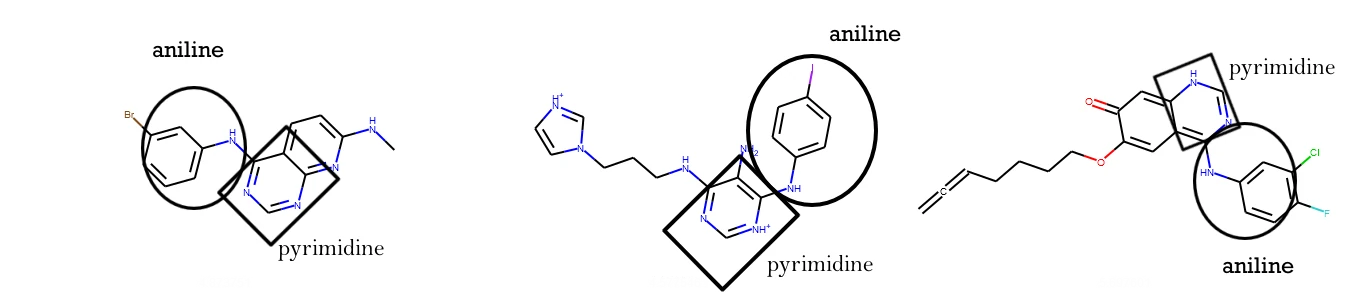


### Advantages of  this model for prediction pic50 from their fingerprint keys.

1. There is no time consuming as laboratory experiments and cheap.
2. It gives general overview about the possible drugs can be used as EGFR inhibitor drugs.

### Disadvantages: 

It does not have enough information about:
1. The model is changed with more variables and there is no fixed procedure to follow in building model. 
2. side effect of the compounds and their toxicity on normal cells.
3. The stereochemistry , stability and also their metabolite that can be produce by liver enzymes and other chemical properties of compounds as it can be used or no.

In general , this Neural network model for prediction of pic50 of molecules form their keys is good as overview to the possible drugs  that can be used in experiments. Therefore , we can reduce the number of experiments on a lot of compounds but I think we cannot take direct molecules from ML models and be 100% assure that these best compounds as EGFR inhibitors drugs. 

## Discussion

### Quiz